In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ignorar algunos elementos molestos...
warnings.filterwarnings("always")

df_train = pd.read_csv("train.csv", index_col=0).assign(test=False)
df_test = pd.read_csv("test.csv", index_col=0).assign(test=True)
df = pd.concat([df_train, df_test])

In [2]:
df.dtypes

Survived    float64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
test           bool
dtype: object

array([[<AxesSubplot:title={'center':'Fare'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'Pclass'}>, <AxesSubplot:>]],
      dtype=object)

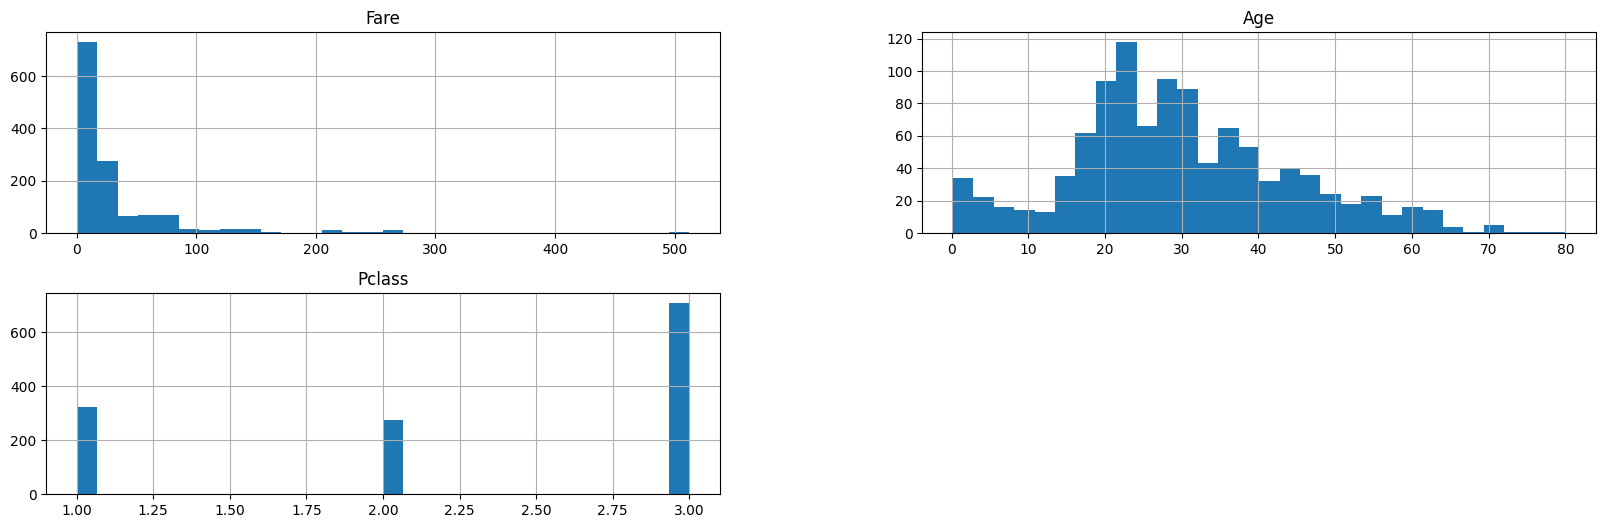

In [3]:
df[["Fare", "Age", "Pclass"]].hist(figsize=(20, 6), bins=30)

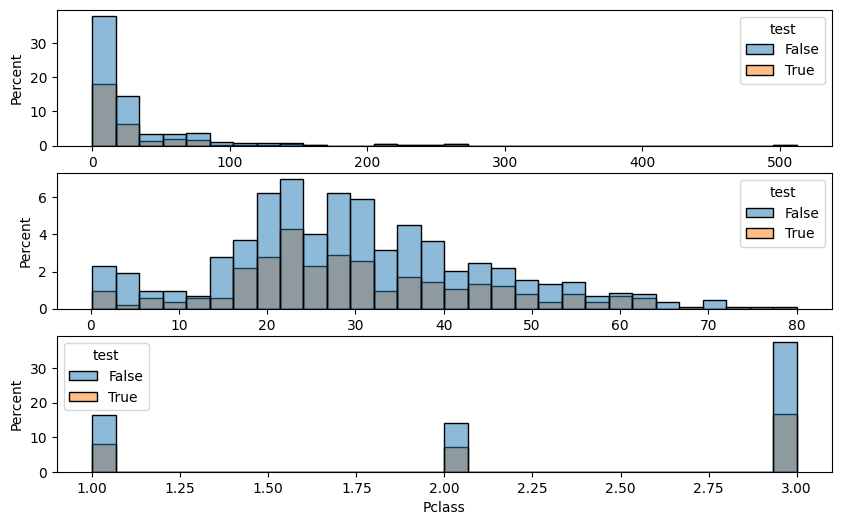

In [4]:
fig, ax = plt.subplots(3, figsize=(10, 6))

for idx, col in enumerate(["Fare", "Age", "Pclass"]):
    sns.histplot(x=col, data=df, hue="test", bins=30, ax=ax[idx], stat="percent")

<AxesSubplot:ylabel='Frequency'>

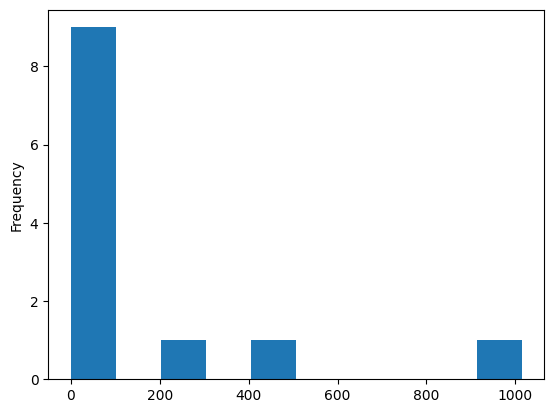

In [5]:
df.isnull().sum().plot(kind="hist")

<AxesSubplot:>

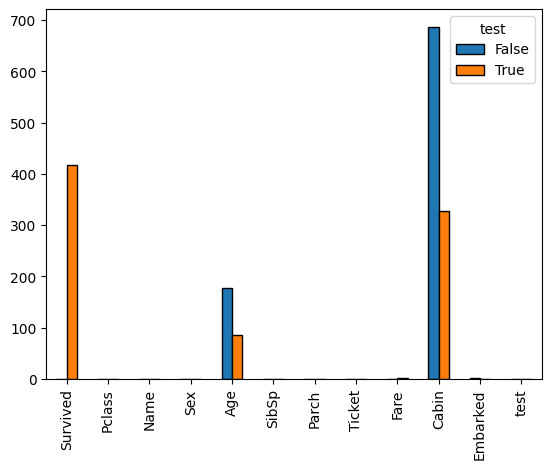

In [6]:
df.groupby("test").apply(lambda x: x.isnull().sum()).T.plot(
    kind="bar", edgecolor="k"
)  # , ylim = [0,50])

## Cross Validation

In [7]:
test_df = pd.DataFrame(dict(a=np.arange(0, 5), b=np.random.rand(5)))
test_df

,a,b
0,0,0.954587
1,1,0.927527
2,2,0.437589
3,3,0.796731
4,4,0.978594


In [8]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(kf.split(test_df)):
    print(f"Train idx: {train_idx}")
    print(f"Train Set Mean: {test_df.loc[train_idx].b.mean()}")
    print(f"Train Set Std: {test_df.loc[train_idx].b.std()}")
    print(f"Test idx: {test_idx}")

test_df.b.agg(["mean", "std"])

Train idx: [1 2 3 4]
Train Set Mean: 0.7851103524515952
Train Set Std: 0.2440112302955961
Test idx: [0]
Train idx: [0 2 3 4]
Train Set Mean: 0.791875353766156
Train Set Std: 0.24958713910290403
Test idx: [1]
Train idx: [0 1 3 4]
Train Set Mean: 0.9143597764111189
Train Set Std: 0.08114666817055667
Test idx: [2]
Train idx: [0 1 2 4]
Train Set Mean: 0.8245744985471848
Train Set Std: 0.258832060020752
Test idx: [3]
Train idx: [0 1 2 3]
Train Set Mean: 0.7791085282923076
Train Set Std: 0.23788417810605
Test idx: [4]


mean    0.819006
std     0.224501
Name: b, dtype: float64

In [9]:
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split  # No es necesario...


def model_pipeline(model):
    pipe = Pipeline(
        steps=[
            ("cat_imp", CategoricalImputer(imputation_method="missing")),
            ("num_imp", MeanMedianImputer(imputation_method="mean")),
            ("ohe", OneHotEncoder()),
            ("sc", StandardScaler()),
            ("model", model),
        ]
    )

    return pipe

In [10]:
X_train = (
    df.query("test == False")
    .drop(columns=["test", "Survived", "Name", "Cabin", "Ticket"])
    .copy()
)
X_test = (
    df.query("test == True")
    .drop(columns=["test", "Survived", "Name", "Cabin", "Ticket"])
    .copy()
)
y_train = df.query("test == False").Survived.copy()

X_train.shape, y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr = model_pipeline(LogisticRegression(random_state=42))


def cv_train(model):
    result = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")
    print(f"{np.mean(result):.3f} +/- {np.std(result):.3f}")


cv_train(lr)

0.714 +/- 0.026


In [12]:
from sklearn.ensemble import BaggingClassifier

bc = BaggingClassifier(
    estimator=LogisticRegression(random_state=42),
    random_state=42,
    n_estimators=20,
    max_samples=0.8,
    max_features=0.8,
)
bc_pipe = model_pipeline(bc)

cv_train(bc_pipe)

0.723 +/- 0.028


In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = model_pipeline(RandomForestClassifier(n_jobs=-1, random_state=42))
cv_train(rf_pipe)

0.755 +/- 0.041


In [14]:
from sklearn.ensemble import GradientBoostingClassifier

gb_pipe = model_pipeline(GradientBoostingClassifier(random_state=42))
cv_train(gb_pipe)

0.761 +/- 0.032


In [15]:
from sklearn.ensemble import AdaBoostClassifier

adab = AdaBoostClassifier(
    estimator=LogisticRegression(),
    random_state=42,
    n_estimators=30,
)
adab_pipe = model_pipeline(adab)
cv_train(adab_pipe)

0.713 +/- 0.022


In [16]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

clf1 = LogisticRegression(random_state=42)
clf2 = DecisionTreeClassifier(random_state=42)
clf3 = KNeighborsClassifier()
clf4 = RandomForestClassifier(n_jobs=-1, random_state=42)

voting = VotingClassifier(
    estimators=[("lr", clf1), ("dt", clf2), ("knn", clf3), ("rf", clf4)],
    voting="soft",
    n_jobs=-1,
)

voting_pipe = model_pipeline(voting)
cv_train(voting_pipe)

0.752 +/- 0.054


In [17]:
from sklearn.ensemble import StackingClassifier

clf5 = GradientBoostingClassifier(random_state=42)
stacking = StackingClassifier(
    estimators=[
        ("lr", clf1),
        ("rf", clf4),
        ("gb", clf5),
    ],
    final_estimator=LogisticRegression(fit_intercept=True, random_state=42),
    cv=3,
    n_jobs=-1,
)

stacking_pipe = model_pipeline(stacking)
cv_train(stacking_pipe)

0.768 +/- 0.036


> Ojo: A veces, combinar modelos no necesariamente da mejor que utilizar modelos solos.

In [18]:
test_labels = pd.read_csv("test_labels.csv")["Survived"]
test_labels

0      0
1      1
2      0
3      0
4      1
      ..
413    0
414    1
415    0
416    0
417    0
Name: Survived, Length: 418, dtype: int64

In [19]:
from sklearn.metrics import f1_score


def eval_model(model, y_test=test_labels, model_name=""):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred)
    print(f"{model_name}: {score}")
    return model


lr_output = eval_model(lr, model_name="LR")
bc_output = eval_model(bc_pipe, model_name="LR Bagging")
adab_output = eval_model(adab_pipe, model_name="Adaboost")
rf_output = eval_model(rf_pipe, model_name="RF")
gb_output = eval_model(gb_pipe, model_name="GB")
voting_output = eval_model(voting_pipe, model_name="Voting")
stacking_output = eval_model(stacking_pipe, model_name="Stacking")

LR: 0.9250814332247558
LR Bagging: 0.9453376205787781
Adaboost: 0.9290322580645162
RF: 0.7459807073954984
GB: 0.8299319727891157
Voting: 0.8013029315960912
Stacking: 0.8344827586206897
